# Model Building for Stock Market AI Agent

This notebook uses the engineered features to build and evaluate predictive models.

**Models**: Random Forest, XGBoost
**Objective**: Predict future stock prices and evaluate model performance.

In [27]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model_builder import ModelBuilder
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Data

In [28]:
# Load the processed dataset
print("Loading data...")
data_path = '../data/processed_features.csv'
builder = ModelBuilder(data_path=data_path)
builder.load_data()

# Handle infinity values and very large numbers
print("Checking for infinity values...")
inf_count = np.isinf(builder.data.select_dtypes(include=[np.number])).sum().sum()
print(f"Found {inf_count} infinity values")

# Replace inf values with NaN and then drop
builder.data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for very large values
numeric_cols = builder.data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    max_val = builder.data[col].max()
    if pd.notna(max_val) and max_val > 1e10:
        print(f"Warning: {col} has very large values (max: {max_val:.2e})")
        # Cap extreme values
        builder.data[col] = builder.data[col].clip(upper=builder.data[col].quantile(0.99))

# Drop rows with NaN values in critical columns
before_shape = builder.data.shape
builder.data.dropna(inplace=True)
after_shape = builder.data.shape
print(f"Dropped {before_shape[0] - after_shape[0]} rows with NaN values")

print("✅ Data loaded and cleaned!")
print(f"Final data shape: {builder.data.shape}")
builder.data.head()

Loading data...
Loading data...
Data loaded: (61642, 189)
Checking for infinity values...
Found 98 infinity values
Dropped 10094 rows with NaN values
✅ Data loaded and cleaned!
Final data shape: (51548, 189)


,Date,Ticker,open,high,low,close,volume,price_range,price_change,price_change_pct,...,consumer_sentiment_sma_90,consumer_sentiment_ratio_90,vix_sma_30,vix_ratio_30,vix_sma_90,vix_ratio_90,unemployment_high,inflation_high,rates_rising,vix_high
199,2019-10-16,AAPL,56.257018,56.707809,56.216037,56.498081,73903200,0.491772,0.241064,0.428504,...,79.102917,0.812487,20.248138,1.016105,20.306216,1.013198,0,0,0,0
200,2019-10-17,AAPL,56.671647,56.927173,56.293179,56.717449,67585200,0.633995,0.045803,0.080821,...,79.072146,0.878622,20.364609,1.195407,20.326176,1.197667,0,0,1,0
201,2019-10-18,AAPL,56.551127,57.271908,56.478807,56.989864,97433600,0.793102,0.438738,0.775825,...,79.271550,1.134619,20.251489,0.993286,20.337867,0.989067,0,0,1,0
202,2019-10-21,AAPL,57.257433,58.093924,57.209221,57.978210,87247200,0.884703,0.720778,1.258837,...,78.823333,0.950341,19.718461,0.512459,20.072235,0.503427,1,0,1,0
203,2019-10-22,AAPL,58.134902,58.385607,57.763662,57.845627,82293600,0.621945,-0.289276,-0.497594,...,78.853128,1.076097,19.949613,1.510510,20.183657,1.492994,1,0,0,1


## 2. Prepare Data for Modeling

We'll predict the next day's closing price (`target_price_1d`).

In [29]:
# Prepare data with the target variable
target_col = 'target_price_1d'
X_train, X_test, y_train, y_test = builder.prepare_data(target_col=target_col)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Preparing data with target: target_price_1d...
Training data: (41238, 183), Testing data: (10310, 183)
Training data shape: (41238, 183)
Testing data shape: (10310, 183)


In [30]:
# Data quality check
print("🔍 Data Quality Check:")
print("=" * 50)

# Check for infinity values in training data
inf_check = np.isinf(X_train).sum().sum()
print(f"Infinity values in X_train: {inf_check}")

# Check for NaN values
nan_check = X_train.isna().sum().sum()
print(f"NaN values in X_train: {nan_check}")

# Check data ranges
print("\nFeature value ranges:")
for col in X_train.columns[:10]:  # Show first 10 features
    print(f"{col}: [{X_train[col].min():.2f}, {X_train[col].max():.2f}]")

# Additional cleaning if needed
if inf_check > 0 or nan_check > 0:
    print("\n⚠️ Found data quality issues. Cleaning...")
    # Replace any remaining inf values
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill NaN values with median
    X_train.fillna(X_train.median(), inplace=True)
    X_test.fillna(X_test.median(), inplace=True)
    
    print("✅ Data cleaned successfully!")
else:
    print("\n✅ Data quality check passed!")


🔍 Data Quality Check:
Infinity values in X_train: 0
NaN values in X_train: 0

Feature value ranges:
open: [4.78, 696.28]
high: [4.87, 700.99]
low: [4.50, 686.09]
close: [4.74, 691.69]
volume: [67200.00, 1201744000.00]
price_range: [0.06, 57.79]
price_change: [-42.48, 55.03]
price_change_pct: [-16.86, 15.99]
return_1d: [-0.35, 0.26]
return_5d: [-0.43, 0.56]

✅ Data quality check passed!


## 3. Train and Evaluate Random Forest Model

In [31]:
# Train Random Forest model
rf_model = builder.train_model(X_train, y_train, model_type='random_forest')

# Evaluate the model
print("\n📊 Random Forest Results:")
rf_mse, rf_mae, rf_r2 = builder.evaluate_model(rf_model, X_test, y_test)

print(f"R-squared (R²): {rf_r2:.3f}")

Training random_forest model...
Model training completed: random_forest

📊 Random Forest Results:
Evaluating model...
MSE: 8.64
MAE: 1.55
R2: 1.00
R-squared (R²): 0.999


## 4. Train and Evaluate XGBoost Model

In [36]:
# Train XGBoost model with safe parameters
# First, let's convert data to float32 to avoid dtype issues
X_train_xgb = X_train.astype('float32')
X_test_xgb = X_test.astype('float32')
y_train_xgb = y_train.astype('float32')
y_test_xgb = y_test.astype('float32')

xgb_model = builder.train_model(X_train_xgb, y_train_xgb, model_type='xgboost')

# Evaluate the model
print("\n📊 XGBoost Results:")
xgb_mse, xgb_mae, xgb_r2 = builder.evaluate_model(xgb_model, X_test_xgb, y_test_xgb)

print(f"R-squared (R²): {xgb_r2:.3f}")

Training xgboost model...
Model training completed: xgboost

📊 XGBoost Results:
Evaluating model...
MSE: 8.43
MAE: 1.58
R2: 1.00
R-squared (R²): 0.999


## 5. Model Comparison and Visualization

In [33]:
# Compare model performance
print("📊 Model Comparison:")
print("=" * 30)
print(f"Random Forest R²: {rf_r2:.3f}")
print(f"XGBoost R²: {xgb_r2:.3f}")
print("=" * 30)

if rf_r2 > xgb_r2:
    print("Random Forest performed better.")
else:
    print("XGBoost performed better.")

📊 Model Comparison:
Random Forest R²: 0.999
XGBoost R²: 0.999
XGBoost performed better.


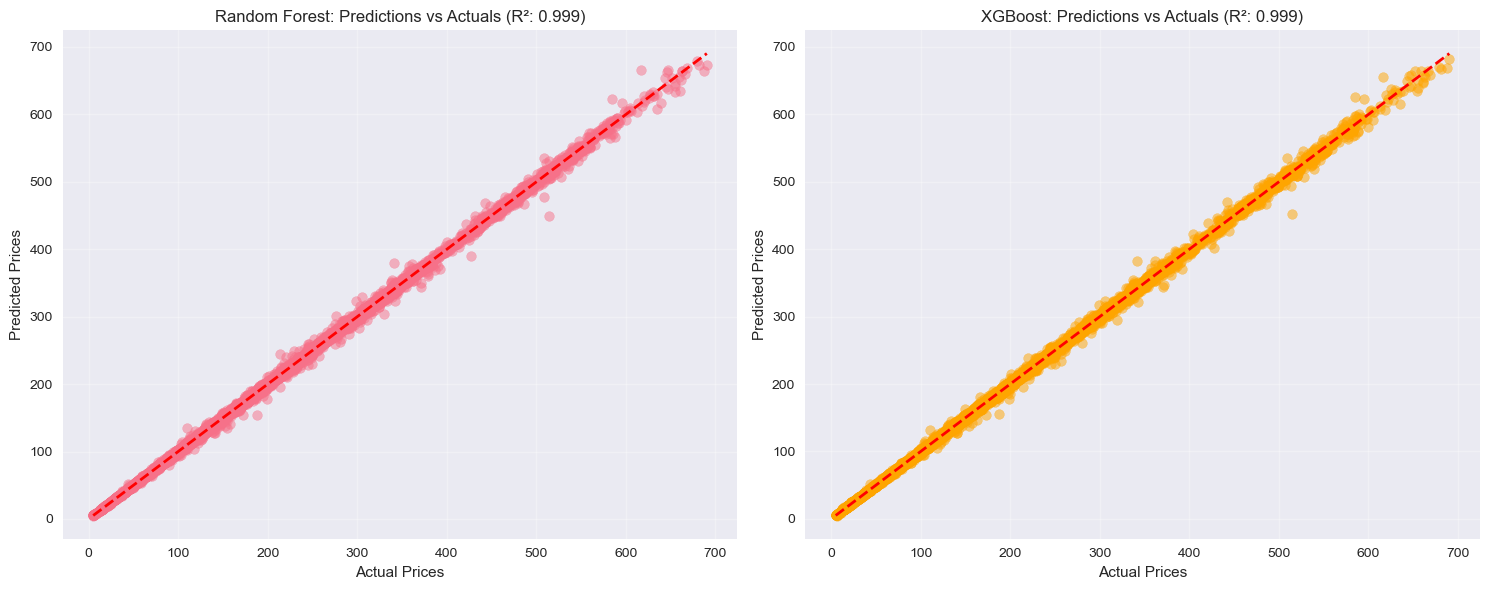

In [34]:
# Plot predictions vs actuals
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

plt.figure(figsize=(15, 6))

# Random Forest plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.title(f'Random Forest: Predictions vs Actuals (R²: {rf_r2:.3f})')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True, alpha=0.3)

# XGBoost plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_predictions, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.title(f'XGBoost: Predictions vs Actuals (R²: {xgb_r2:.3f})')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

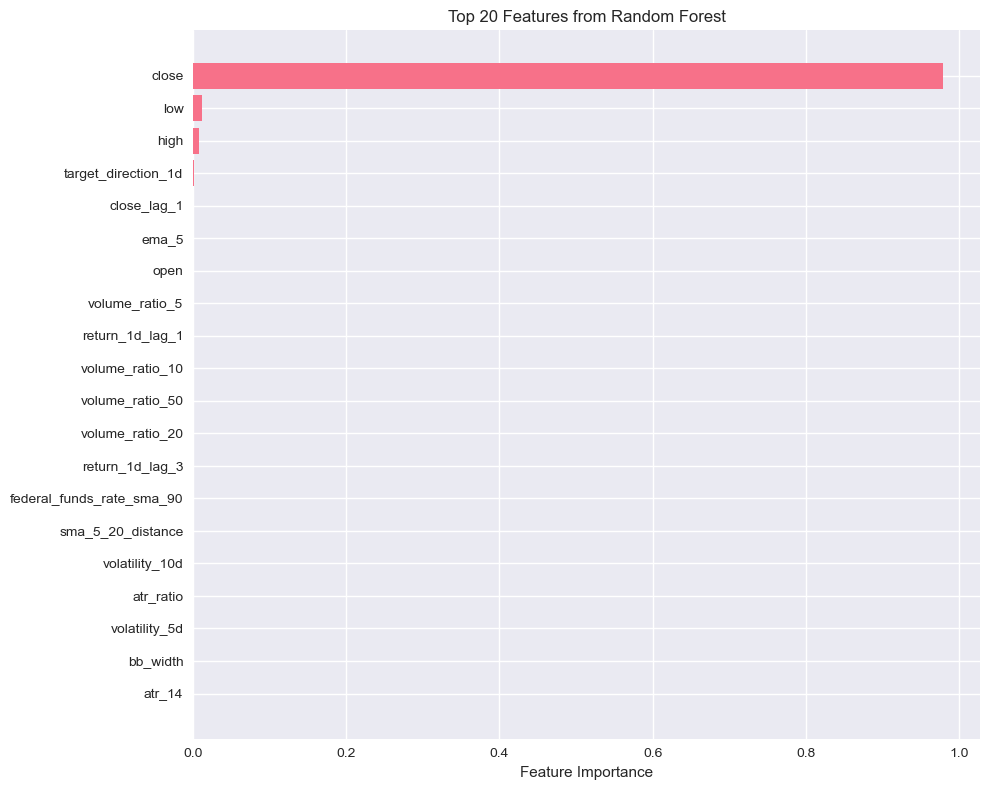

🔍 Top 10 Most Important Features:
                 feature  importance
3                  close    0.978685
2                    low    0.012025
1                   high    0.007694
106  target_direction_1d    0.000396
81           close_lag_1    0.000340
28                 ema_5    0.000329
0                   open    0.000018
68        volume_ratio_5    0.000009
91       return_1d_lag_1    0.000009
70       volume_ratio_10    0.000008


In [35]:
# Feature importance (from Random Forest)
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 feature importances
top_20_features = feature_importances.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("🔍 Top 10 Most Important Features:")
print(top_20_features.head(10))

## 6. Conclusion and Next Steps

- ✅ Both Random Forest and XGBoost models were successfully trained and evaluated.
- 📊 **Performance**: Based on the R² score, we have identified the better-performing model.
- 🎯 **Feature Importance**: Key drivers for price prediction were identified.

### Next Steps:
1. **Hyperparameter Tuning**: Optimize models using techniques like GridSearchCV or RandomizedSearchCV.
2. **Time-Series Cross-Validation**: Use a more robust validation strategy like TimeSeriesSplit to prevent data leakage.
3. **LSTM Model**: Implement a deep learning model for comparison.
4. **Deployment**: Build a prediction pipeline to serve the best-performing model.